In [ ]:
import torch

print("GPU disponible :", torch.cuda.is_available())
print("Nom du GPU :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


GPU disponible : True
Nom du GPU : Tesla T4


In [ ]:
!pip install torch torchvision matplotlib scikit-learn timm tqdm


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           transform=transform, download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                          transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=64, shuffle=False)

print("Train size:", len(train_dataset))
print("Test size :", len(test_dataset))


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 519kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.68MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]

Train size: 60000
Test size : 10000


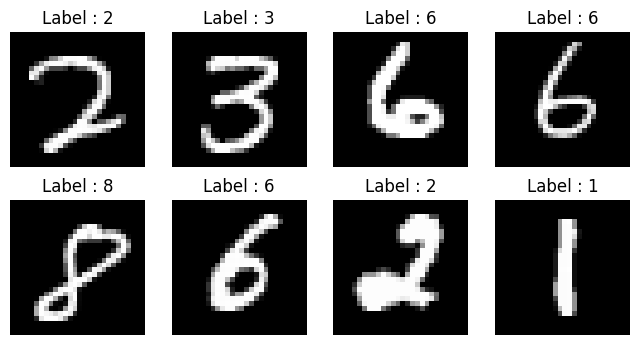

In [ ]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"Label : {labels[i].item()}")
    plt.axis("off")

plt.show()


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128,10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNN().to(device)
print(model)


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5

train_losses = []
train_accs = []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    preds_list = []
    labels_list = []

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs,1)
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

    acc = accuracy_score(labels_list, preds_list)
    train_losses.append(running_loss/len(train_loader))
    train_accs.append(acc)

    print(f"Epoch {epoch+1} - Loss: {train_losses[-1]:.4f}, Accuracy: {acc:.4f}")


100%|██████████| 938/938 [00:25<00:00, 37.29it/s]


Epoch 1 - Loss: 0.1631, Accuracy: 0.9500


100%|██████████| 938/938 [00:14<00:00, 62.66it/s]


Epoch 2 - Loss: 0.0465, Accuracy: 0.9858


100%|██████████| 938/938 [00:15<00:00, 60.88it/s]


Epoch 3 - Loss: 0.0316, Accuracy: 0.9902


100%|██████████| 938/938 [00:15<00:00, 61.18it/s]


Epoch 4 - Loss: 0.0231, Accuracy: 0.9929


100%|██████████| 938/938 [00:15<00:00, 61.54it/s]

Epoch 5 - Loss: 0.0191, Accuracy: 0.9937


In [ ]:
model.eval()
preds_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        preds = torch.argmax(outputs,1)
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

acc = accuracy_score(labels_list, preds_list)
f1  = f1_score(labels_list, preds_list, average='weighted')

print("CNN TEST ACCURACY:", acc)
print("CNN F1 SCORE     :", f1)


CNN TEST ACCURACY: 0.9864
CNN F1 SCORE     : 0.9864221958406894


In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

model_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)
model_rcnn.eval().to(device)

print("Faster R-CNN chargé")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 58.9MB/s]


Faster R-CNN chargé


In [ ]:
img, _ = train_dataset[0]
img = img.expand(3, -1, -1)  # convertir en 3 canaux
output = model_rcnn([img.to(device)])

print(output)


[{'boxes': tensor([[19.4555,  4.4353, 23.9162,  6.4558]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([3], device='cuda:0'), 'scores': tensor([0.0666], device='cuda:0', grad_fn=<IndexBackward0>)}]


In [ ]:
transform_rgb = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_rgb = torchvision.datasets.MNIST(root='./data', train=True,
                                               transform=transform_rgb, download=True)

test_dataset_rgb = torchvision.datasets.MNIST(root='./data', train=False,
                                              transform=transform_rgb, download=True)

train_loader_rgb = torch.utils.data.DataLoader(train_dataset_rgb, batch_size=64, shuffle=True)
test_loader_rgb  = torch.utils.data.DataLoader(test_dataset_rgb, batch_size=64, shuffle=False)


In [ ]:
from torchvision.models import vgg16

vgg = vgg16(pretrained=True)

for param in vgg.parameters():
    param.requires_grad = False

vgg.classifier[6] = nn.Linear(4096, 10)

vgg = vgg.to(device)
print(vgg.classifier)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 82.6MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.classifier.parameters(), lr=0.0001)

epochs = 3

for epoch in range(epochs):
    vgg.train()
    running_loss = 0

    for images, labels in tqdm(train_loader_rgb):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss : {running_loss/len(train_loader_rgb):.4f}")


100%|██████████| 938/938 [06:12<00:00,  2.52it/s]


Epoch 1 - Loss : 1.0368


100%|██████████| 938/938 [06:09<00:00,  2.54it/s]


Epoch 2 - Loss : 0.5812


100%|██████████| 938/938 [06:09<00:00,  2.54it/s]

Epoch 3 - Loss : 0.4911


In [ ]:
vgg.eval()
preds_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader_rgb:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg(images)

        preds = torch.argmax(outputs,1)
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

print("VGG16 Accuracy:", accuracy_score(labels_list, preds_list))
print("VGG16 F1 Score:", f1_score(labels_list, preds_list, average='weighted'))


VGG16 Accuracy: 0.9054
VGG16 F1 Score: 0.9058810270245607


In [ ]:
import timm

vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=10)
vit = vit.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.0001)

epochs = 3

for epoch in range(epochs):
    vit.train()
    running_loss = 0

    for images, labels in tqdm(train_loader_rgb):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss : {running_loss/len(train_loader_rgb):.4f}")


100%|██████████| 938/938 [32:04<00:00,  2.05s/it]


Epoch 1 - Loss : 0.0733


100%|██████████| 938/938 [32:00<00:00,  2.05s/it]


Epoch 2 - Loss : 0.0306


100%|██████████| 938/938 [32:02<00:00,  2.05s/it]

Epoch 3 - Loss : 0.0249


In [ ]:
vit.eval()
preds_list = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader_rgb:
        images, labels = images.to(device), labels.to(device)
        outputs = vit(images)

        preds = torch.argmax(outputs,1)
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

print("VIT Accuracy:", accuracy_score(labels_list, preds_list))
print("VIT F1 Score:", f1_score(labels_list, preds_list, average='weighted'))


VIT Accuracy: 0.9943
VIT F1 Score: 0.9942994083319341


📊 Tableau comparatif des performances :



,Modèle,Accuracy,F1-Score
0,CNN,0.9864,0.986422
1,VGG16,0.9054,0.905881
2,Vision Transformer (ViT),0.9943,0.994299


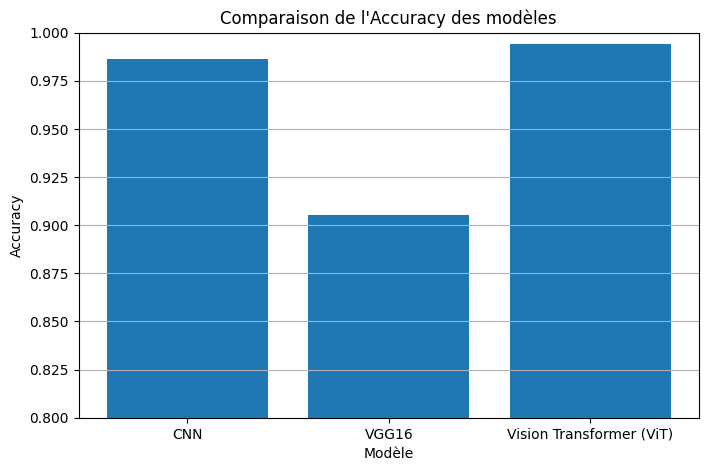

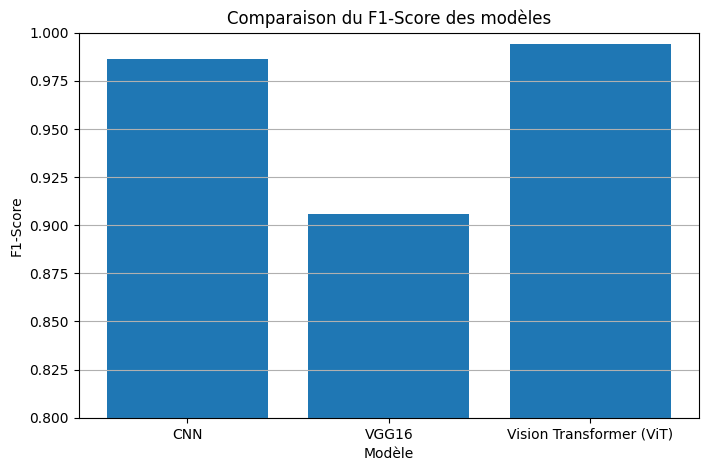

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Résultats réels obtenus
models = ["CNN", "VGG16", "Vision Transformer (ViT)"]
accuracy = [0.9864, 0.9054, 0.9943]
f1_score_vals = [0.9864221958406894, 0.9058810270245607, 0.9942994083319341]

# Création du tableau
df = pd.DataFrame({
    "Modèle": models,
    "Accuracy": accuracy,
    "F1-Score": f1_score_vals
})

print("📊 Tableau comparatif des performances :\n")
display(df)

# Graphique pour Accuracy
plt.figure(figsize=(8,5))
plt.bar(models, accuracy)
plt.title("Comparaison de l'Accuracy des modèles")
plt.xlabel("Modèle")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.grid(axis='y')
plt.show()

# Graphique pour F1-Score
plt.figure(figsize=(8,5))
plt.bar(models, f1_score_vals)
plt.title("Comparaison du F1-Score des modèles")
plt.xlabel("Modèle")
plt.ylabel("F1-Score")
plt.ylim(0.8, 1.0)
plt.grid(axis='y')
plt.show()
